In [ ]:
from google.colab import files
uploaded = files.upload()

Saving uci-news-aggregator.csv to uci-news-aggregator.csv


In [ ]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

User uploaded file "uci-news-aggregator.csv" with length 102895657 bytes


In [ ]:
import pandas as pd
import io
news = pd.read_csv(io.StringIO(uploaded['uci-news-aggregator.csv'].decode('utf-8')))

In [ ]:
news.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


In [ ]:
import numpy as np
import pandas as pd
!pip install sklearn_evaluation
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn_evaluation.plot import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer

  Created wheel for sklearn-evaluation: filename=sklearn_evaluation-0.5-cp36-none-any.whl size=28646 sha256=01ce05bb3cb27f8c321144e04c073acc7022daa424e9285f3c336ac065880377
  Stored in directory: /root/.cache/pip/wheels/a8/38/0d/9103d63a0189c6e3b4ecc6f03e40c1b6762b1ff55612a7313c
Successfully built sklearn-evaluation


In [ ]:
news['CATEGORY'].unique()

array(['b', 't', 'e', 'm'], dtype=object)

(-1.101639420124838,
 1.1000780787490432,
 -1.1090927453255768,
 1.1174362845275305)

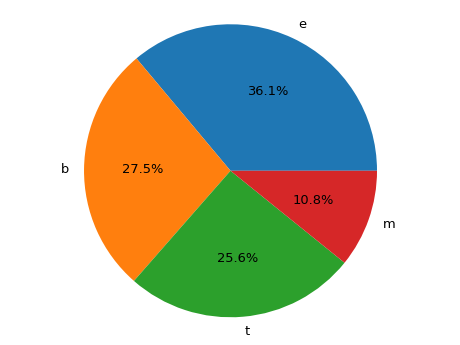

In [ ]:
news.CATEGORY.value_counts().plot(kind='pie', 
                                  figsize=(8,6), 
                                  fontsize=13, 
                                  autopct='%1.1f%%', 
                                  wedgeprops={'linewidth': 5}
                                  )
plt.axis('off')
plt.axis('equal')

In [ ]:
news['TITLE'] = news['TITLE'].str.replace('[^\w\s]','').str.lower()

In [ ]:
# convert data to vectors
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(news['TITLE'])

y = news['CATEGORY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 30% split

# fit and score the bayesian classifier
mnb = MultinomialNB(alpha=1)
mnb.fit(X_train, y_train)
mnb.score(X_test, y_test)

0.9285781923204394

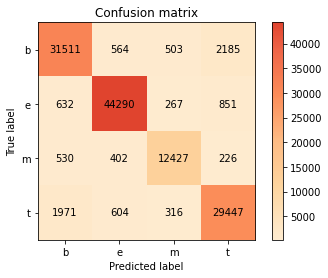

In [ ]:
confusion_matrix(y_test, mnb.predict(X_test), target_names = ['b','e','m','t']).grid(False)

In [ ]:
sgd = SGDClassifier(n_jobs=-1, max_iter=10, random_state=1234)

# hyperparameters for tuning
sgd_grid = [{'loss': ['hinge', 'log', 'squared_hinge'],
             'alpha': [0.0001, 0.0001, 0.00001]}]

# grid search with cross validation
sgd_search = GridSearchCV(estimator=sgd, param_grid=sgd_grid, cv=5, refit=True)
sgd_search.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=10,
                                     n_iter_no_change=5, n_jobs=-1,
                                     penalty='l2', power_t=0.5,
                                     random_state=1234, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [0.0001, 0.0001, 1e-05],
                          'loss': ['hinge', 'log', 'squared_hinge']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
      

In [ ]:
sgd_search.best_params_

{'alpha': 1e-05, 'loss': 'hinge'}

In [ ]:
sgd_search.best_estimator_.score(X_test, y_test)

0.9482742294398939

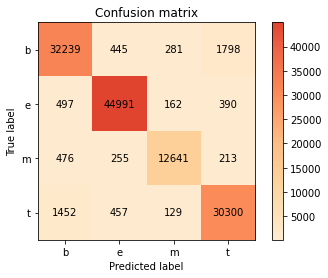

In [ ]:
confusion_matrix(y_test, sgd_search.best_estimator_.predict(X_test), target_names = ['b','e','m','t']).grid(False)

In [ ]:
# title-category function
def title_to_category(title):
    categories = {'b' : 'business', 
                  't' : 'science and technology', 
                  'e' : 'entertainment', 
                  'm' : 'health'}
    pridicter = sgd_search.best_estimator_.predict(vectorizer.transform([title]))
    return categories[pridicter[0]]

In [ ]:
# sample predictions using our sgd classifier on 2017 BBC headlines
print('news title', '                                 ', 'category', '\n' 
      'Bank of England staff to go on strike', '      ', title_to_category('Bank of England staff to go on strike'), '\n'
      'Trump stance could damage Earth - Hawking', '  ', title_to_category('Trump stance could damage Earth - Hawking'), '\n'
      'Olivia de Havilland sues over TV show', '      ', title_to_category('Olivia de Havilland sues over TV show')
     )

news title                                   category 
Bank of England staff to go on strike        business 
Trump stance could damage Earth - Hawking    science and technology 
Olivia de Havilland sues over TV show        entertainment


In [ ]:
# testing a headline from The Onion
title_to_category("Johnson & Johnson introduces 'nothing but tears shampoo' to 'toughen up' infants.")
# link to article: http://www.theonion.com/article/johnson-johnson-introduces-nothing-but-tears-shamp-2506

'health'

In [ ]:
# another one from The Onion
title_to_category("Archaeological Dig Uncovers Ancient Race Of Skeleton People.")

'science and technology'

In [ ]:
title_to_category("Lady Gaga heads out in NYC wearing just lingerie and sexy fishnets.")

'entertainment'